In [3]:

from pprint import pprint
import matplotlib.pyplot as plt

from math import pi, sin, cos, sqrt
from math import radians as rad
from math import degrees as deg

from direct.showbase.ShowBase import ShowBase
from direct.task import Task
from direct.actor.Actor import Actor
from direct.interval.IntervalGlobal import Sequence
from panda3d.core import Point3

from direct.showbase.ShowBase import ShowBase
from direct.showbase.DirectObject import DirectObject
from direct.gui.DirectGui import *
from direct.interval.IntervalGlobal import *
from panda3d.core import lookAt
from panda3d.core import GeomVertexFormat, GeomVertexData
from panda3d.core import Geom, GeomTriangles, GeomVertexWriter
from panda3d.core import Texture, GeomNode
from panda3d.core import PerspectiveLens
from panda3d.core import CardMaker
from panda3d.core import Light, Spotlight
from panda3d.core import TextNode
from panda3d.core import LVector3
import sys
import os

# по P получается оно вращается из - вращения по l

speedCam = 0
cam_mode = 1

omegaR = 50
a = 6 / 2
b = 4 / 2
c = 2 / 2
nowP = 5 # внести погрешность
omegaP = 0

last_time = None
how = 0

t_list = []
fi_list = []
ε_list = []
omegaP_list = []

class MyApp(ShowBase):
    def __init__(self):
        ShowBase.__init__(self)

        # Load the environment model.
        self.scene = self.loader.loadModel("models/environment")
        self.scene.reparentTo(self.render)

        # Disable the camera trackball controls.
        self.disableMouse()

        # Add the spinCameraTask procedure to the task manager.
        self.taskMgr.add(self.spinCameraTask, "SpinCameraTask")

        # Add the spinCameraTask procedure to the task manager.
        self.taskMgr.add(self.big_rotation, "big_rotation")

        # Add the spinCameraTask procedure to the task manager.
        self.taskMgr.add(self.jony_rotation, "jony_rotation")
        

    # Define a procedure to move the camera.
    def spinCameraTask(self, task):
        global speedCam, cube
        if cam_mode == 1:
            angleDegrees = task.time * speedCam + 80
            angleRadians = angleDegrees * (pi / 180.0)
            self.camera.setPos(18 * sin(angleRadians), -18 * cos(angleRadians), 20)
            self.camera.setHpr(angleDegrees, -14, 0)
        else:
            self.camera.setPos(-16 * cos(rad(cube.getR())), 0, 16 * sin(rad(cube.getR())) + 15)
            self.camera.setHpr(-90, 0, )
        return Task.cont
    
    def big_rotation(self, task):
        global cube, omegaR
        cube.setR(task.time * omegaR)
        
        return Task.cont
    
    def jony_rotation(self, task):
        global cube, last_time, omegaR, omegaP, m, nowP, how
        
        if last_time is None:
            last_time = task.time

        fi = rad(nowP)

        r = c * sin(fi)

        ε = (r * (rad(omegaR) ** 2) * (c * cos(fi))) / ((c ** 2))

        omegaP += ε * (task.time - last_time)

        nowP = nowP + deg(omegaP) * (task.time - last_time)

        cube.setP(nowP)

        last_time = task.time

        global t_list, fi_list, ε_list, omegaP_list

        t_list.append(task.time)
        fi_list.append(fi)
        ε_list.append(ε)
        omegaP_list.append(omegaP)

        
        return Task.cont


base = MyApp()
base.disableMouse()
base.camera.setPos(0, -10, 0)

title = OnscreenText(text="Simulation of the Janibekov Effect",
                     style=1, fg=(1, 1, 1, 1), pos=(-0.1, 0.1), scale=.07,
                     parent=base.a2dBottomRight, align=TextNode.ARight)
escapeEvent = OnscreenText(text="Performed by Vorobyov Igor B09-202",
                           style=1, fg=(1, 1, 1, 1), pos=(0.06, -0.08),
                           align=TextNode.ALeft, scale=.05,
                           parent=base.a2dTopLeft)


# You can't normalize inline so this is a helper function
def normalized(*args):
    myVec = LVector3(*args)
    myVec.normalize()
    return myVec

# helper function to make a square given the Lower-Left-Hand and
# Upper-Right-Hand corners

def makeSquare(x1, y1, z1, x2, y2, z2, col):
    format = GeomVertexFormat.getV3n3cpt2()
    vdata = GeomVertexData('square', format, Geom.UHDynamic)

    vertex = GeomVertexWriter(vdata, 'vertex')
    normal = GeomVertexWriter(vdata, 'normal')
    color = GeomVertexWriter(vdata, 'color')
    texcoord = GeomVertexWriter(vdata, 'texcoord')

    # make sure we draw the sqaure in the right plane
    if x1 != x2:
        vertex.addData3(x1, y1, z1)
        vertex.addData3(x2, y1, z1)
        vertex.addData3(x2, y2, z2)
        vertex.addData3(x1, y2, z2)

        normal.addData3(normalized(2 * x1 - 1, 2 * y1 - 1, 2 * z1 - 1))
        normal.addData3(normalized(2 * x2 - 1, 2 * y1 - 1, 2 * z1 - 1))
        normal.addData3(normalized(2 * x2 - 1, 2 * y2 - 1, 2 * z2 - 1))
        normal.addData3(normalized(2 * x1 - 1, 2 * y2 - 1, 2 * z2 - 1))

    else:
        vertex.addData3(x1, y1, z1)
        vertex.addData3(x2, y2, z1)
        vertex.addData3(x2, y2, z2)
        vertex.addData3(x1, y1, z2)

        normal.addData3(normalized(2 * x1 - 1, 2 * y1 - 1, 2 * z1 - 1))
        normal.addData3(normalized(2 * x2 - 1, 2 * y2 - 1, 2 * z1 - 1))
        normal.addData3(normalized(2 * x2 - 1, 2 * y2 - 1, 2 * z2 - 1))
        normal.addData3(normalized(2 * x1 - 1, 2 * y1 - 1, 2 * z2 - 1))

    # adding different colors to the vertex for visibility
    for _ in range(4):
        if col == 1:
            color.addData4f(1.0, 0.0, 0.0, 1.0)
        elif col == 2:
            color.addData4f(0.0, 1.0, 0.0, 1.0)
        elif col == 3:
            color.addData4f(0.0, 0.0, 1.0, 1.0)
        else:
            color.addData4f(1.0, 0.0, 1.0, 1.0)

    texcoord.addData2f(0.0, 1.0)
    texcoord.addData2f(0.0, 0.0)
    texcoord.addData2f(1.0, 0.0)
    texcoord.addData2f(1.0, 1.0)

    # Quads aren't directly supported by the Geom interface
    # you might be interested in the CardMaker class if you are
    # interested in rectangle though
    tris = GeomTriangles(Geom.UHDynamic)
    tris.addVertices(0, 1, 3)
    tris.addVertices(1, 2, 3)

    square = Geom(vdata)
    square.addPrimitive(tris)
    return square

# Note: it isn't particularly efficient to make every face as a separate Geom.
# instead, it would be better to create one Geom holding all of the faces.

square0 = makeSquare(-a, -b, -c, a, -b, c, 1)
square1 = makeSquare(-a, b, -c, a, b, c, 1)
square2 = makeSquare(-a, b, c, a, -b, c, 2)
square3 = makeSquare(-a, b, -c, a, -b, -c, 2)
square4 = makeSquare(-a, -b, -c, -a, b, c, 3)
square5 = makeSquare(a, -b, -c, a, b, c, 3)
snode = GeomNode('square')
snode.addGeom(square0)
snode.addGeom(square1)
snode.addGeom(square2)
snode.addGeom(square3)
snode.addGeom(square4)
snode.addGeom(square5)


"""l = 3
big = 2
little = 1

snode = GeomNode('square')
new0 = makeSquare(l, l, 0, -l, -l, 0, 1)
new1 = makeSquare(l + little, little, 0, l - little, -little, 0, 2)
new2 = makeSquare(-l + little, little, 0, -l - little, -little, 0, 2)
new3 = makeSquare(big, l + big, 0, -big, l - big, 0, 3)
new4 = makeSquare(big, -l + big, 0, -big, -l - big, 0, 3)
snode.addGeom(new0)
snode.addGeom(new1)
snode.addGeom(new2)
snode.addGeom(new3)
snode.addGeom(new4)"""

cube = render.attachNewNode(snode)

# OpenGl by default only draws "front faces" (polygons whose vertices are
# specified CCW).
cube.setTwoSided(True)

cube.set_pos(0, 0, 15)

class MyTapper(DirectObject):

    def __init__(self):
        #self.testTexture = loader.loadTexture("maps/envir-reeds.png")
        self.accept("1", self.toggleTex)
        self.accept("2", self.toggleLightsSide)
        self.accept("3", self.toggleLightsUp)

        self.LightsOn = False
        self.LightsOn1 = False
        slight = Spotlight('slight')
        slight.setColor((1, 1, 1, 1))
        lens = PerspectiveLens()
        slight.setLens(lens)
        self.slnp = render.attachNewNode(slight)
        self.slnp1 = render.attachNewNode(slight)

    def toggleTex(self):
        global cube
        if cube.hasTexture():
            cube.setTextureOff(1)
        else:
            cube.setTexture(self.testTexture)

    def toggleLightsSide(self):
        global cube
        self.LightsOn = not self.LightsOn

        if self.LightsOn:
            render.setLight(self.slnp)
            self.slnp.setPos(cube, 10, -400, 0)
            self.slnp.lookAt(10, 0, 0)
        else:
            render.setLightOff(self.slnp)

    def toggleLightsUp(self):
        global cube
        self.LightsOn1 = not self.LightsOn1

        if self.LightsOn1:
            render.setLight(self.slnp1)
            self.slnp1.setPos(cube, 10, 0, 400)
            self.slnp1.lookAt(10, 0, 0)
        else:
            render.setLightOff(self.slnp1)

t = MyTapper()
base.run()



Known pipe types:
  CocoaGraphicsPipe
(all display modules loaded.)


SystemExit: 

/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/IPython/core/interactiveshell.py:3406: UserWarning: To exit: use 'exit', 'quit', or Ctrl-D.
  warn("To exit: use 'exit', 'quit', or Ctrl-D.", stacklevel=1)


<ErrorbarContainer object of 3 artists>

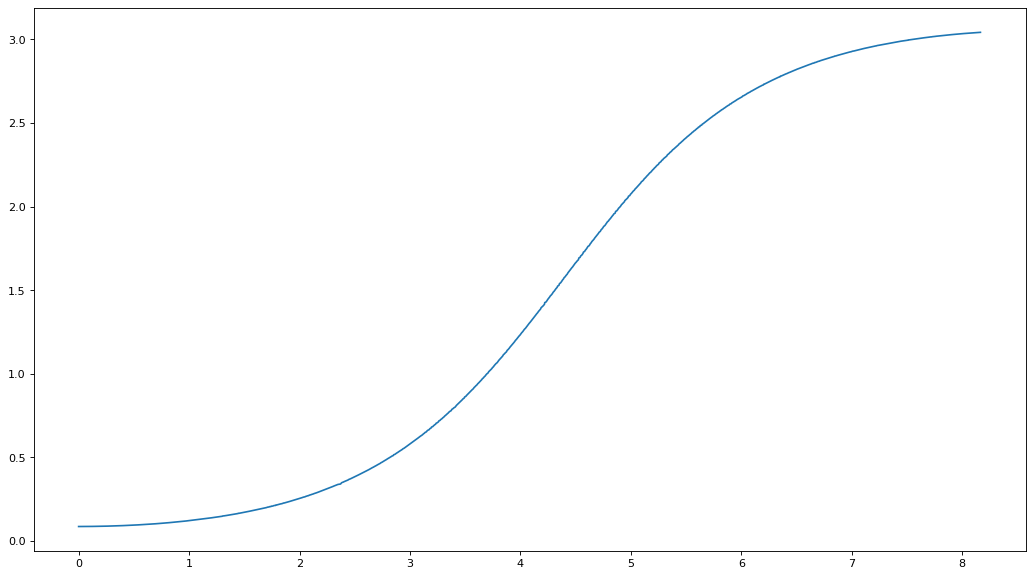

In [4]:
plt.figure(figsize=(16, 9), dpi=80)
plt.errorbar(x=t_list, y=fi_list)

<ErrorbarContainer object of 3 artists>

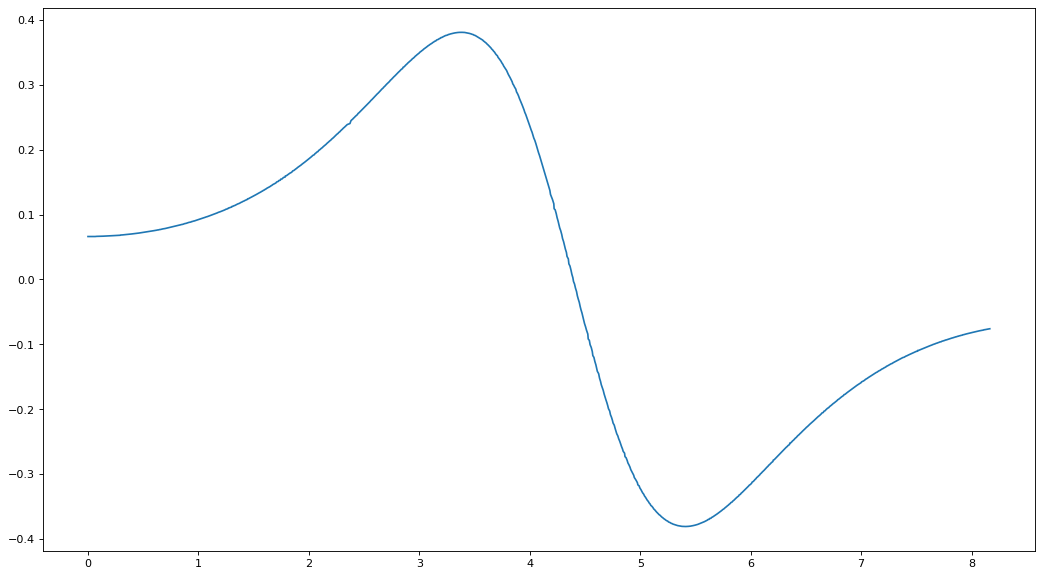

In [5]:
plt.figure(figsize=(16, 9), dpi=80)
plt.errorbar(x=t_list, y=ε_list)

<ErrorbarContainer object of 3 artists>

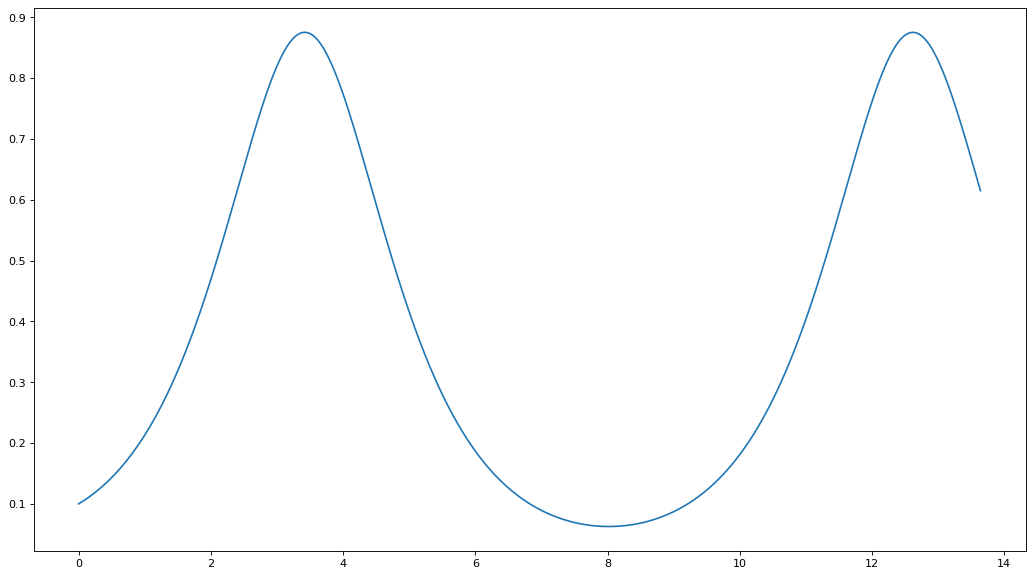

In [ ]:
plt.figure(figsize=(16, 9), dpi=80)
plt.errorbar(x=t_list, y=omegaP_list)